In [1]:
from pomegranate import *
from itertools import product
#!pip install varname
import matplotlib.pyplot as plt
import copy
plt. rcParams['figure.figsize']  = (20,20)
#!pip install pygraphviz

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
cells =list(product((list(range(1,5))),repeat=2))

In [3]:
class Location():
    
    def __init__(self, x=1, y=1):
        self.x = x
        self.y = y
        self.location = (self.x,self.y)
        
    
    def is_adjacent(loc1, loc2) -> bool:
        x1 = loc1[0]
        x2 = loc2[0]
        y1 = loc1[1]
        y2 = loc2[1]
       
        if (x1 == x2) and (y1 == (y2 - 1)) or \
           (x1 == x2) and (y1 == (y2 + 1)) or \
           (x1 == (x2 - 1)) and (y1 == y2) or \
           (x1 == (x2 + 1)) and (y1 == y2):
            return True
        return False
    
    def same_loc (loc1, loc2) -> bool:
        return loc1[0] == loc2[0] and loc1[1] == loc2[1]


In [4]:
class WumpusEnvironment():
    
    def __init__(self, width = 4, height = 4, allow_climb_without_gold= True, pit_prob = 0.2):
        #we'll set pit probability to 0 for testing purposes to force agent to find gold
       
        self.grid_size = (width,height)
        self.grid = width
        self.x_start, self.y_start = (1, 1)
        self.x_end, self.y_end = (self.grid,self.grid)
        self.pit_prob = pit_prob
        self.allow_climb_without_gold = allow_climb_without_gold
        self.agent_loc = Location(self.x_start, self.y_start)
        self.agent_loc.x,self.agent_loc.y=self.agent_loc.x, self.agent_loc.y
        self.orientation = 'RIGHT'
        self.agent_alive = True
        self.agent_has_arrow = True
        self.agent_has_gold = False
        self.wumpus_alive = True
        self.scream = False
        self.make_things()
        self.make_percepts()
        self.wumpus_location = self.thing_position('wumpus')
        self.game_over = False
        self.score=0
        self.bump = False

        
    def make_things(self) -> tuple[dict,list,tuple]:
        from itertools import product
        import random
        self.cells =list(product((list(range(1,5))),repeat=2))
        self.things =  {key: [] for key in cells}
        self.pits = []
        
#create pits:

        for x in range(self.x_start, self.x_end + 1):
            for y in range(self.y_start, self.y_end+1):
                if (x != 1) or (y != 1):
                    if random.random() < self.pit_prob:
                        self.pits.append((x, y))
                        self.things[(x,y)].append('pit')
                                            
#create wumpus
        self.wumpus=(random.randint(self.x_start, self.x_end), random.randint(self.y_start, self.y_end))
        
        while self.wumpus==(self.x_start,self.y_start):
            self.wumpus=(random.randint(self.x_start, self.x_end), random.randint(self.y_start, self.y_end))
        self.things[self.wumpus].append('wumpus')
                     
#create gold:
        self.gold=(random.randint(self.x_start, self.x_end), random.randint(self.y_start, self.y_end))
        while self.gold==(self.x_start,self.y_start):
            self.gold=(random.randint(self.x_start, self.x_end), random.randint(self.y_start, self.y_end))
        self.things[self.gold].append('gold')
             
        return self.things,self.pits,self.gold,self.wumpus
    

#to find location of wumpus and gold:
    def thing_position(self,thing) -> tuple:
        keys=list(self.things.keys())
        values=list(self.things.values())

        try:
            values.index([thing])
            position = values.index([thing])
        except:
            try: 
                for sublist in values:
                    if thing in sublist:
                        position = values.index(sublist)
            except:
                print('exception ocurred')
        return (keys[position])
    
    
#create percepts
    def make_percepts(self) -> dict: 
        self.percepts = {key: [] for key in self.cells}
        for cell in self.percepts.keys():
            for pit in self.pits:
                if  Location.is_adjacent(cell, pit) and 'breeze' not in self.percepts[cell]:
                    self.percepts[cell].append('breeze')
           
            if Location.is_adjacent(cell,self.wumpus)or Location.same_loc(cell,self.wumpus):
                 self.percepts[cell].append('stench')

            if Location.same_loc(cell,self.gold):
                self.percepts[cell].append('glitter')
        return self.percepts
        
    
#pass percepts to an agent for the cell it's in:    
    def get_percepts_and_score(self) -> list:
        import copy
        temp_percepts = copy.deepcopy(self.percepts[(self.agent_loc.x, self.agent_loc.y)])
        if self.bump:
            temp_percepts.append('bump')
            self.bump = False
        
        elif self.scream:
            temp_percepts.append('scream')
            self.scream = False
        temp_percepts.append(self.score)
        
       
        return temp_percepts


#to track how agent's actions affect the environment:
    def take_action(self,action):

            if action == 'forward':
                if self.orientation == 'RIGHT':
                    if  self.agent_loc.x < self.grid:
                        self.agent_loc.x += 1
                    else:
                        self.bump = True
                elif self.orientation == 'UP':
                    if self.agent_loc.y < self.grid:
                        self.agent_loc.y += 1
                    else:
                        self.bump = True

                elif self.orientation == 'LEFT':
                    if self.agent_loc.x > 1:
                        self.agent_loc.x -= 1
                    else:
                        self.bump = True

                elif self.orientation == 'DOWN':
                    if self.agent_loc.y > 1:
                        self.agent_loc.y -= 1
                    else:
                         self.bump = True      


            if action == 'turn_left':
                if self.orientation == 'RIGHT':
                    self.orientation = 'UP'
                elif self.orientation == 'UP':
                    self.orientation = 'LEFT'
                elif self.orientation == 'LEFT':
                    self.orientation = 'DOWN'
                elif self.orientation == 'DOWN':
                    self.orientation = 'RIGHT'

            if action == 'turn_right':
                if self.orientation == 'RIGHT':
                    self.orientation = 'DOWN'
                elif self.orientation == 'UP':
                    self.orientation = 'RIGHT'
                elif self.orientation == 'LEFT':
                    self.orientation = 'UP'
                elif self.orientation == 'DOWN':
                    self.orientation = 'LEFT'

            
            if action == 'grab':
                if not self.agent_has_gold and (self.agent_loc.x, self.agent_loc.y)==self.thing_position('gold'):
                    self.agent_has_gold = True   
                else:
                    print("Illegal action 'GRAB'")

            if action == 'shoot':
                if  self.agent_has_arrow:
                    self.agent_has_arrow = False
                    self.score-=10

                    if self.wumpus_alive:
                        if (((self.orientation == 'RIGHT') and
                             (self.agent_loc.x < self.wumpus_location[0]) and
                             (self.agent_loc.y == self.wumpus_location[1])) or

                            ((self.orientation == 'UP') and
                             (self.agent_loc.x == self.wumpus_location[0]) and
                             (self.agent_loc.y < self.wumpus_location[1])) or

                            ((self.orientation == 'LEFT') and
                             (self.agent_loc.x > self.wumpus_location[0]) and
                             (self.agent_loc.y == self.wumpus_location[1])) or

                            ((self.orientation == 'DOWN') and
                             (self.agent_loc.x == self.wumpus_location[0]) and
                             (self.agent_loc.y > self.wumpus_location[1]))):
                            self.wumpus_alive = False
                            self.scream = True

                else:
                    print('No arrows!')



            if action == 'climb':
                if self.agent_loc.x == self.x_start and\
                self.agent_loc.y == self.y_start:
                    if self.agent_has_gold:
                        self.score+=1000
                        self.end_of_round()
                    else:
                        self.end_of_round()
                else:
                    print('Illegal action! You cannot climb outside of start square!')
                    
            if  ((self.agent_loc.x, self.agent_loc.y)==self.wumpus_location and self.wumpus_alive) or \
                ((self.agent_loc.x, self.agent_loc.y) in self.pits):
                    self.agent_alive = False
                    self.score-=1000
                    #print(f"You've encountered a {'pit' if (self.agent_loc.x, self.agent_loc.y) in self.pits else 'wumpus'}!")
                    self.end_of_round()
            self.score-=1
                
   
    def end_of_round(self) ->int:
        if self.agent_alive and self.agent_has_gold:
            file_input = "Congratulations! You won! " 
                   
        else:
            file_input  = "Wa-Wa-Wa-Waaa! You lose! "
        self.game_over = True
        final_score = f"Final score: {self.score}\n"
        file_input = file_input+final_score
        file = open('testing_results.txt','a')
        file.write(file_input) # Write some text
        file.close()
        
        return self.score
         

#visualize the game:
    def print_world(self):
        """ print_world: print the current wumpus world"""

        # print out the first horizontal line
        out = "+"
        for x in range(1, self.grid + 1):
            out += "---+"
        print(out)

        for y in range(self.grid, 0, -1):  
            out = "|"

            for x in range(1, self.grid + 1):
                if self.wumpus_location[0] == x and self.wumpus_location[1]==y:
                    if self.wumpus_alive:
                        out += "W"
                    else:
                        out += "M"   #dead wumpus is upside down
                else:
                    out += " "

                if not self.agent_has_gold and self.thing_position('gold')[0] == x and\
                self.thing_position('gold')[1] ==y:
                    out += "G"
                else:
                    out += " "

                _has_pit = False
                for pit in self.pits:
                    if pit[0] == x and pit[1]==y:
                        _has_pit = True
                if _has_pit:
                    out += "P"
                else:
                    out += " "

                out += "|"

            print(out)
            out = "|"
            
#print the agent:
            for x in range(1, self.grid + 1):
                if self.agent_alive and self.agent_loc.x == x and self.agent_loc.y == y:
                    if self.orientation == 'RIGHT':
                        out += " A>|"
                    elif self.orientation == 'UP':
                        out += " A^|"
                    elif self.orientation == 'LEFT':
                        out += " A<|"
                    else:
                        out += " Av|"
                else:
                    out += "   |"

            print(out)
            out = "+"

            # print out the final horizontal line
            for x in range(1, self.grid + 1):
                out += "---+"

            print(out)

#print the current percepts and score for the agent's location
        print(self.get_percepts_and_score())
        print()

In [5]:
adjacent = {key:[]  for key in cells} #create list of adjacent locations for each cell
for key in adjacent:
    for k in cells:  #whether or not (1,1) is adjacent isn't important, as we can't 
        #have a pit or a wumpus there
        if Location.is_adjacent(key,k):
            adjacent[key].append(k)

In [6]:
wumpus_dict = {(1,1):0}
wumpus_dict.update({cell: 1/15 for cell in cells[1:]})
wumpus_dist = DiscreteDistribution(wumpus_dict)

In [7]:
stenches = {key:[] for key in cells}
stench_locs = copy.deepcopy(adjacent)

In [8]:
#create a conditional table for a stench in a specified location
def condit_stench_table(stench_loc, adj_table, wumpus_loc) ->list: 
    stench_locs = adj_table[stench_loc]
    stench_locs.append(stench_loc)
    all_locs = [cell for cell in cells]
    table_true = []
    table_false = []
    for entry in all_locs:
        if entry in stench_locs:
            table_true.append([entry, True, 1])
            table_false.append([entry, False, 0])
        else:
            table_true.append(([entry,True, 0]))
            table_false.append([entry, False, 1])
    table =  [item for sublist in zip(table_true, table_false) for item in sublist]
    table=ConditionalProbabilityTable(table,[wumpus_loc])
    return table

In [9]:
#create a dict of conditional tables for stenches at each grid location:
for key in stenches:
    stenches[key] = condit_stench_table(key,stench_locs, wumpus_dist)

In [10]:
s0 = Node(wumpus_dist, name = 'wumpus_dist')
s11 = Node(stenches[(1,1)], name = "s11")
s12 = Node(stenches[(1,2)], name = "s12")
s13 = Node(stenches[(1,3)], name = "s13")
s14 = Node(stenches[(1,4)], name = "s14")
s21 = Node(stenches[(2,1)], name = "s21")
s22 = Node(stenches[(2,2)], name = "s22")
s23 = Node(stenches[(2,3)], name = "s23")
s24 = Node(stenches[(2,4)], name = "s24")
s31 = Node(stenches[(3,1)], name = "s31")
s32 = Node(stenches[(3,2)], name = "s32")
s33 = Node(stenches[(3,3)], name = "s33")
s34 = Node(stenches[(3,4)], name = "s34")
s41 = Node(stenches[(4,1)], name = "s41")
s42 = Node(stenches[(4,2)], name = "s42")
s43 = Node(stenches[(4,3)], name = "s43")
s44 = Node(stenches[(4,4)], name = "s44")
stench_nodes = [s11,s12,s13,s14,s21,s22,s23,s24,s31,s32,s33,s34,s41,s42,s43,s44]

In [11]:
stench_model = BayesianNetwork('stench_model')
stench_model.add_states(s0,s11,s12,s13,s14,s21,s22, s23, s24, s31, s32, s33, s34, s41, s42,s43, s44)
for stench in stench_nodes:
    stench_model.add_edge(s0,stench)

stench_model.plot()

In [12]:
stench_model.bake()


In [13]:
print(len(stench_model.edges), len(stench_model.states))

16 17


In [14]:
stench_model.predict_proba({})

array([{
           "class" : "Distribution",
           "dtype" : "tuple",
           "name" : "DiscreteDistribution",
           "parameters" : [
               {
                   "(1, 1)" : 0.0,
                   "(1, 2)" : 0.06666666666666667,
                   "(1, 3)" : 0.06666666666666667,
                   "(1, 4)" : 0.06666666666666667,
                   "(2, 1)" : 0.06666666666666667,
                   "(2, 2)" : 0.06666666666666667,
                   "(2, 3)" : 0.06666666666666667,
                   "(2, 4)" : 0.06666666666666667,
                   "(3, 1)" : 0.06666666666666667,
                   "(3, 2)" : 0.06666666666666667,
                   "(3, 3)" : 0.06666666666666667,
                   "(3, 4)" : 0.06666666666666667,
                   "(4, 1)" : 0.06666666666666667,
                   "(4, 2)" : 0.06666666666666667,
                   "(4, 3)" : 0.06666666666666667,
                   "(4, 4)" : 0.06666666666666667
               }
           ],
     

In [15]:
#create a model for pits:
pitProb = {True: 0.2, False: 0.8 }
pit11 = DiscreteDistribution({True:0, False:1})
pit12 = DiscreteDistribution(pitProb)
pit13 = DiscreteDistribution(pitProb)
pit14 = DiscreteDistribution(pitProb)
pit21 = DiscreteDistribution(pitProb)
pit22 = DiscreteDistribution(pitProb)
pit23 = DiscreteDistribution(pitProb)
pit24 = DiscreteDistribution(pitProb)
pit31 = DiscreteDistribution(pitProb)
pit32 = DiscreteDistribution(pitProb)
pit33 = DiscreteDistribution(pitProb)
pit34 = DiscreteDistribution(pitProb)
pit41 = DiscreteDistribution(pitProb)
pit42 = DiscreteDistribution(pitProb)
pit43 = DiscreteDistribution(pitProb)
pit44 = DiscreteDistribution(pitProb)
pit_dist = [pit11,pit12,pit13,pit14,pit21,pit22,pit23,pit24,pit31,pit32,pit33,pit34,pit41,pit42,pit43,pit44]

In [16]:
#we have to modify is_adjacent function, as we need to grab pit location from a variable name
def pit_adjacent(loc1, loc2) -> bool:
    
    def namestr(obj, namespace) ->str:
        return [name for name in namespace if namespace[name] is obj]

    loc2 = namestr(loc2, globals())[0]
    x1 = loc1[0]
    x2 = eval(loc2[-2]) #we get location as string, but we need integer for comparison
    y1 = loc1[1]
    y2 = eval(loc2[-1])

    if (x1 == x2) and (y1 == (y2 - 1)) or \
       (x1 == x2) and (y1 == (y2 + 1)) or \
       (x1 == (x2 - 1)) and (y1 == y2) or \
       (x1 == (x2 + 1)) and (y1 == y2):
        return True
    return False

In [17]:
def breeze_condit_table(breeze_loc,adj_table)->list:
    vals = [False, True]
    #create lists of all possible combinations of T and F values of length (# of adjacent cells + 1)
    table=list(list(tup) for tup in product(vals, repeat=len(adj_table[breeze_loc])+1))
    for sublist in table:
        if all(sublist) or not any(sublist): #all T or all F values in a table produce probability of 1
            sublist.append(1)
        elif sublist[-1]:
            if any(sublist[:-1]): #if any adjacent value is T and value at percept cell is T, probability is 1
                sublist.append(1)
            else:
                sublist.append(0)
        else:
            sublist.append(0)
     
    #the parents need to be added in the same order as entries in the table, so entries have to be sorted:
    cond_table=ConditionalProbabilityTable(table, 
                                           [entry for entry in pit_dist if pit_adjacent(breeze_loc,entry)])
    return cond_table

In [18]:
#create a dict of conditional tables for each breeze location in the grid:
breezes = {cell:[]for cell in cells}
for key in breezes:
    breezes[key]=breeze_condit_table(key,adjacent)

In [19]:
p11 = Node(pit11, name = "p11")
p12 = Node(pit12, name = "p12")
p13 = Node(pit13, name = "p13")
p14 = Node(pit14, name = "p14")
p21 = Node(pit21, name = "p21")
p22 = Node(pit22, name = "p22")
p23 = Node(pit23, name = "p23")
p24 = Node(pit24, name = 'p24')
p31 = Node(pit31, name = "p31")
p32 = Node(pit32, name = "p32")
p33 = Node(pit33, name = 'p33')
p34 = Node(pit34, name = "p34")
p41 = Node(pit41, name = "p41")
p42 = Node(pit42, name = "p42")
p43 = Node(pit43, name = "p43")
p44 = Node(pit44, name = "p44")
pit_nodes = [p11,p12,p13,p14,p21,p22,p23,p24,p31,p32,p33,p34,p41,p42,p43,p44]

In [20]:
b11 = Node(breezes[(1,1)], name = "b11")
b12 = Node(breezes[(1,2)], name = "b12")
b13 = Node(breezes[(1,3)], name = "b13")
b14 = Node(breezes[(1,4)], name = "b14")
b21 = Node(breezes[(2,1)], name = "b21")
b22 = Node(breezes[(2,2)], name = "b22")
b23 = Node(breezes[(2,3)], name = "b23")
b24 = Node(breezes[(2,4)], name = "b24")
b31 = Node(breezes[(3,1)], name = "b31")
b32 = Node(breezes[(3,2)], name = "b32")
b33 = Node(breezes[(3,3)], name = "b33")
b34 = Node(breezes[(3,4)], name = "b34")
b41 = Node(breezes[(4,1)], name = "b41")
b42 = Node(breezes[(4,2)], name = "b42")
b43 = Node(breezes[(4,3)], name = "b43")
b44 = Node(breezes[(4,4)], name = "b44")
breeze_nodes = [b11,b12,b13,b14,b21,b22,b23,b24,b31,b32,b33,b34,b41,b42, b43, b44]

In [21]:
pit_model = BayesianNetwork('Pit Model')

In [22]:
pit_model.add_states(*pit_nodes,*breeze_nodes)

In [23]:
def breeze_adjacent(loc1, loc2) -> bool:
        loc1 = loc1.name
        loc2 = loc2.name
        x1 = eval(loc1[-2])
        x2 = eval(loc2[-2])
        y1 = eval(loc1[-1])
        y2 = eval(loc2[-1])
       
        if (x1 == x2) and (y1 == (y2 - 1)) or \
           (x1 == x2) and (y1 == (y2 + 1)) or \
           (x1 == (x2 - 1)) and (y1 == y2) or \
           (x1 == (x2 + 1)) and (y1 == y2):
            return True
        return False

In [24]:
for breeze in breeze_nodes:
    for pit in pit_nodes: 
        if breeze_adjacent(breeze,pit):
            pit_model.add_edge(pit,breeze)

pit_model.plot()

In [25]:
pit_model.bake()

In [26]:
print(len(pit_model.edges),len(pit_model.states))

48 32


##### 

In [28]:
class BeelineAgent():
    def __init__(self,grid):
        import networkx as nx
        self.agent_type = 'beeline_agent'
        self.actions = ['forward', 'turn_left', 'turn_right']  #We will remove some actions from the action list for testing purposes.
        #our agent is random and we want to force it to find gold occasionally
        self.latest_percept = []
        self.has_gold = False
        self.score = None
        self.agent_loc = Location(1,1)
        self.orientation = 'RIGHT'
        self.safe_locations = []
        self.latest_action = None
        self.grid = grid
        self.extra_turn = False
        self.target_loc = None
        self.target_orientation = None
        self.graph = nx.grid_2d_graph(range(1,self.grid+1), range(1,self.grid+1)) #initialize 4x4 graph
    

#logic for choosing next action:    
    def next_action(self) -> str :
        
        safe_location = (self.agent_loc.x,self.agent_loc.y)
        self.safe_locations.append(safe_location)
            
        if self.has_gold and self.agent_loc.x==1 and self.agent_loc.y==1:
            self.latest_action = 'climb'
        
        elif self.has_gold:
            
            if self.extra_turn or self.latest_action in ['turn_right', 'turn_left']:
                self.target_loc = self.target_loc
            else:
                self.target_loc = self.shortest_path.pop(0)
        
            self.target_orient=self.find_target_orientation\
            ((self.target_loc),(self.agent_loc.x,self.agent_loc.y) )  
            
            if self.target_orient==self.orientation:
                    self.extra_turn = False
                    self.latest_action = "forward"
                   
            elif self.target_orient!=self.orientation:
                self.latest_action = self.change_orientation(self.orientation, self.target_orient)
                if self.target_orient!=self.orientation:
                    self.extra_turn = True
                     
        elif not self.has_gold and 'glitter' in self.latest_percept:
            self.has_gold = True
            self.latest_action = 'grab'
            self.build_path_back()
                  
        else:
            self.latest_action = self.move_to_target()
        
        self.track_location()
        return self.latest_action
    
    def move_to_target(self):
        import random
        action = random.choice(self.actions)
        return action
        
      

#to self-track agent's location:
    def track_location(self):
        if self.latest_action == 'forward':
                if self.orientation == 'RIGHT':
                    if  self.agent_loc.x < self.grid:
                        self.agent_loc.x += 1
                
                elif self.orientation == 'UP':
                    if self.agent_loc.y < self.grid:
                        self.agent_loc.y += 1

                elif self.orientation == 'LEFT':
                    if self.agent_loc.x > 1:
                        self.agent_loc.x -= 1

                elif self.orientation == 'DOWN':
                    if self.agent_loc.y > 1:
                        self.agent_loc.y -= 1
                    
        if self.latest_action == 'turn_left':
            if self.orientation == 'RIGHT':
                self.orientation = 'UP'
            elif self.orientation == 'UP':
                self.orientation = 'LEFT'
            elif self.orientation == 'LEFT':
                self.orientation = 'DOWN'
            elif self.orientation == 'DOWN':
                self.orientation = 'RIGHT'

        if self.latest_action == 'turn_right':
            if self.orientation == 'RIGHT':
                self.orientation = 'DOWN'
            elif self.orientation == 'DOWN':
                self.orientation = 'LEFT'
            elif self.orientation == 'LEFT':
                self.orientation = 'UP'
            elif self.orientation == 'UP':
                self.orientation = 'RIGHT'
                
#to update latest percept:    
    def perceive(self, percept):
        self.latest_percept = percept
           

 #reinitialize the agent for the new game:
    def new_game(self,grid):
        return BeelineAgent(grid)


#to plot networkX graph:
    def plot_graph(self, graph):
        import networkx as nx
        import matplotlib.pyplot as plt
        pos = {(x,y):(x,y) for x,y in graph.nodes()}
        nx.draw(graph, pos=pos, node_color='lightgreen', with_labels=True, node_size=600)
        plt.show()
        

#to build the shortest safe path back
    def build_path_back(self) ->list:
        import networkx as nx
        
        safe_nodes = self.safe_locations
        safe_nodes.append((1,1))
        unsafe_nodes = [node for node in list(self.graph.nodes) if node not in safe_nodes]
        self.graph.remove_nodes_from(unsafe_nodes) #remove all nodes with unknown safety
        start_node = (self.agent_loc.x,self.agent_loc.y)
        end_node = (1,1)
        def dist(a, b):   #to calculate Euclidean distance
            (x1, y1) = a
            (x2, y2) = b
            return ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5
        self.shortest_path = nx.astar_path(self.graph, start_node, end_node, heuristic = dist)
        #remove nodes that are not on the shortest path:
        remove_nodes=[node for node in list(self.graph.nodes) if node not in self.shortest_path]
        self.path_back = self.graph
        self.path_back.remove_nodes_from(remove_nodes) 
        #self.plot_graph(self.path_back) #visualize the shortest path
        #print(self.shortest_path)
        self.shortest_path.pop(0) #to remove current location
        return self.shortest_path


#to identify if change of orientation is required: 
    def find_target_orientation(self,target_loc,current_loc) ->str:
        target_location = Location(*target_loc)
        current_loc = Location(*current_loc)
        
        if target_location.x==current_loc.x+1 and target_location.y==current_loc.y:
            self.target_orientation = "RIGHT"
        elif target_location.x==current_loc.x-1 and target_location.y==current_loc.y:
            self.target_orientation = "LEFT"
        elif target_location.x==current_loc.x and target_location.y==current_loc.y+1:
            self.target_orientation = "UP"
        elif target_location.x==current_loc.x and target_location.y==current_loc.y-1:
            self.target_orientation = "DOWN"
        return self.target_orientation


#to execute change of orientation:
    def change_orientation(self,current_orientation, target_orientation) ->str:
        if target_orientation == "DOWN":
            if current_orientation == "UP" or current_orientation == "RIGHT":
                self.latest_action = "turn_right"
            elif current_orientation == "LEFT":
                self.latest_action = "turn_left"

        elif target_orientation == "UP":
            if current_orientation == "DOWN" or current_orientation == "LEFT":
                self.latest_action = "turn_right"
            elif current_orientation == "RIGHT":
                self.latest_action = "turn_left"

        elif target_orientation == "RIGHT":
            if current_orientation == "LEFT" or current_orientation == "UP":
                self.latest_action = "turn_right"
            elif current_orientation == "DOWN":
                self.latest_action = "turn_left"

        elif target_orientation == "LEFT":
            if current_orientation == "RIGHT" or current_orientation == "DOWN":
                self.latest_action = "turn_right"
            elif current_orientation == "UP":
                self.latest_action = "turn_left"
        return self.latest_action

In [29]:
class ProbAgent(BeelineAgent):
    
    def __init__(self, stench_model = stench_model, pit_model = pit_model,grid=4):
        super().__init__(grid)
        self.agent_type = 'prob_agent'
        self.stench_model = stench_model
        self.pit_model = pit_model
        self.wumpus_screamed = False
        self.cells =list(product((list(range(1,5))),repeat=2))
        self.percept_history = {cell:[]for cell in self.cells}
        self.adjacent_cells = self.find_adjacent()
        self.unexplored_cells = self.cells
        self.damage_control = False
        self.has_arrow = True
        self.no_wumpus_cells = []
        
#updating history of percepts:
    def update_percepts(self,agent_loc,latest_percept)->list:
        self.percept_history.update({agent_loc: latest_percept})
        return self.percept_history
    
    def perceive(self, percept):
        self.latest_percept = percept
        self.update_percepts((self.agent_loc.x,self.agent_loc.y),self.latest_percept)
        if self.latest_action == 'shoot':
            if 'scream' in self.latest_percept:
                self.wumpus_screamed = True
            else:
                self.no_wumpus_cells = []
                if self.orientation == 'RIGHT':
                    self.no_wumpus_cells.extend((x,self.agent_loc.y)for x in range(self.agent_loc.x,self.grid+1))
                elif self.orientation == 'LEFT':
                    self.no_wumpus_cells.extend((x,self.agent_loc.y)for x in range(self.agent_loc.x,0,-1))
                elif self.orientation == 'UP':
                    self.no_wumpus_cells.extend((self.agent_loc.x,y)for y in range(self.agent_loc.y,self.grid+1))
                else:
                    self.no_wumpus_cells.extend((self.agent_loc.x,y)for y in range(self.agent_loc.y,0,-1))
                #print(f"no wumpus here:{self.no_wumpus_cells}")
                
          
    def find_adjacent(self)->dict:
        adjacent = {key:[]  for key in self.cells} #create list of adjacent locations for each cell
        for key in adjacent:
            for k in cells:  
                if Location.is_adjacent(key,k):
                    adjacent[key].append(k)
        return adjacent

    
    def view_probs(self,target_loc):
        #print(f"target_location:{target_loc}")
    
        def change_to_state_name(cell):
            state_name=''.join(str(cell)).replace("(","").replace(")","").replace(", ","")
            return state_name
          
        #to map cell indices to predict_proba indices:
        stench_percepts = {f"s{change_to_state_name(key)}":(True if 'stench' in value else False)\
                           for key,value in self.percept_history.items() if value}
        if self.wumpus_screamed:
            self.wumpus_prob = 0                                  
        
        elif self.has_arrow == False and target_loc in self.no_wumpus_cells:
                self.wumpus_prob = 0 
        else:
            self.wumpus_prob = stench_model.predict_proba(stench_percepts)
            self.wumpus_prob=self.wumpus_prob[0].parameters[0][target_loc]
           
        
        breeze_percepts = {f"b{change_to_state_name(key)}":(True if 'breeze' in value else False)\
                           for key,value in self.percept_history.items() if value}
        pit_prob = pit_model.predict_proba([breeze_percepts])
    
        pit_idx = {key:cells.index(key) for key in cells} #mapping of cell to pit idx in the table.
        
        pit_prob=pit_prob[0][pit_idx[target_loc]].parameters[0][True]
        
        #probability of one of the two independent events happening = P(pit)+pit(wumpus)-(P(pit)* P(wumpus))
        self.prob_death = pit_prob+self.wumpus_prob-(pit_prob*self.wumpus_prob)
        return self.prob_death, self.wumpus_prob,pit_prob
    
    def target_cell(self,agent_loc):
        import random
        safe_cells = self.safe_locations
        adjacent_cells = self.adjacent_cells[agent_loc]
        unsafe_cells = []
        for cell in cells:
            prob_death, wumpus_prob,pit_prob = self.view_probs(cell)
            if prob_death>0.5:
                unsafe_cells.append(cell)
                #print(f"unsafe cell{cell}detected. Chance of wumpus:{wumpus_prob}, chance of pit: {pit_prob}, probability of death:{prob_death}\n")
        self.unexplored_cells = [cell for cell in cells if cell not in safe_cells and cell not in unsafe_cells]
        
        new_cell = []
        for cell in adjacent_cells:
            if cell in self.unexplored_cells:
                new_cell.append(cell)
        if new_cell:
            self.target_loc = random.choice(new_cell)
        else:
            for cell in adjacent_cells:
                if cell in safe_cells:
                    count=safe_cells.count(cell)
                    if count<=3:
                        new_cell.append(cell)
        if new_cell:
            self.target_loc = random.choice(new_cell)
        else:
            self.build_path_back()
            self.damage_control = True
            self.target_loc = (1,1)
        return self.target_loc
    
    def kill_wumpus(self) ->str:
        wumpus_detected  = dict.fromkeys(self.adjacent_cells[(self.agent_loc.x,self.agent_loc.y)])
        for cell in wumpus_detected:
            _,wumpus_prob,_ = self.view_probs(cell)
            wumpus_detected[cell] = wumpus_prob
        for k,v in wumpus_detected.items():
            if v>=0.5:
                self.target_loc = k
            elif k in self.unexplored_cells:
                self.target_loc = k
            else:
                pass
        self.target_orient=self.find_target_orientation\
    ((self.target_loc),(self.agent_loc.x,self.agent_loc.y) ) 
        if self.target_orient==self.orientation:
            self.extra_turn = False
            self.latest_action = 'shoot'
            self.has_arrow = False
            
        elif self.target_orientation!=self.orientation:
            self.latest_action = self.change_orientation(self.orientation, self.target_orient)
        #print(f"wumpus probabiliy:{wumpus_detected}")
        return self.latest_action

    
    def move_to_target(self)->str:

        if self.damage_control and self.agent_loc.x==1 and self.agent_loc.y==1:
            self.latest_action = 'climb'
        elif 'stench' in self.latest_percept and self.has_arrow and not self.wumpus_screamed:
            self.latest_action = self.kill_wumpus()
        else:
            if self.extra_turn or self.latest_action in ['turn_right', 'turn_left']:
                self.target_loc = self.target_loc        

            elif self.damage_control:
                if self.extra_turn or self.latest_action in ['turn_right', 'turn_left']:
                    self.target_loc = self.target_loc
                elif self.shortest_path:
                    self.target_loc = self.shortest_path.pop(0)
                else:
                    self.target_loc = self.target_loc
    
            else:
                self.target_loc = self.target_cell((self.agent_loc.x,self.agent_loc.y)) 

            self.target_orient=self.find_target_orientation\
            ((self.target_loc),(self.agent_loc.x,self.agent_loc.y) )  

            if self.target_orient==self.orientation:
                    self.extra_turn = False
                    self.latest_action = "forward"

            elif self.target_orientation!=self.orientation:
                self.latest_action = self.change_orientation(self.orientation, self.target_orient)
                if self.target_orientation!=self.orientation:
                    self.extra_turn = True           
        
        prob_death,chance_wump,chance_pit = self.view_probs(self.target_loc)
        #print(f"Target cell:{self.target_loc}, chance of wumpus there:{chance_wump},\
        #chance of pit:{chance_pit}, chance of death:{prob_death}")
        
       
            
        return self.latest_action
    
    def new_game(self,grid):
        return ProbAgent(grid)

In [31]:
def game_engine(agent, env=WumpusEnvironment()):
    new_game = "Y"
    num_games = 0
    total_score = 0
    avg_score = 0
    while new_game in["Y","y"]: 
        
        #since agent is random, we need a condition to break the while loop:
        if agent.agent_type in ['naive_agent','beeline_agent']:
            max_moves = 10
            i=1
            
            while not env.game_over  and i<=max_moves+1:
                print(f"Move {i}.")
                env.print_world() 
                current_percept = env.get_percepts_and_score()
                print(current_percept)
                agent.perceive(current_percept)
                next_action=agent.next_action()
                print(f"next action: {next_action}")
                env.take_action(next_action)
                i+=1
       
        else: 
            file = open('testing_results.txt','a')
            file_input= f"Game # {num_games+1}:\n"
            file.write(file_input) 
            file.close()
            while not env.game_over:
                #env.print_world() 
                current_percept = env.get_percepts_and_score()
                agent.perceive(current_percept)
                next_action=agent.next_action()
                env.take_action(next_action)
                
            total_score +=env.score   
            num_games+=1
            avg_score = total_score/num_games
        
        if num_games<=25:
            new_game = "Y"
        else:
            new_game = "N"
        #new_game= input("Do you want to play again? Y or N\n")
        if new_game in["Y","y"]:
            env=WumpusEnvironment()
            agent = agent.new_game(env.grid)
        else:
            print("Thank you for playing!") 
    file = open('testing_results.txt','a')
    file_input=f"/ntotal score after 1000 games:{total_score}, average score per game:{avg_score}"
    file.write(file_input) # Write some text
    file.close()
    return total_score
    #print(f"total score after 1000 games:{total_score}, average score per game:{avg_score}")

In [ ]:
score_after_1000=0
for i in range(41):
    partition_score = 0
    file = open('testing_results.txt','a')
    file.write(f" Partition {i}\n")
    partition_score=game_engine(ProbAgent(4)) 
    avg_partition_score = partition_score/50
    
    file_input=f"\ntotal score after partition {i}:{partition_score}, average score per game:{avg_partition_score}"
    file.write(file_input) # Write some text
    file.close()
    
    score_after_1000+=partition_score

In [35]:
print(score_after_1000)

202418


Do you want to play again? Y or N
y
Move 1.
+---+---+---+---+
|  P|   |   |   |
|   |   |   |   |
+---+---+---+---+
|   |   |   |   |
|   |   |   |   |
+---+---+---+---+
|   | G |  P|  P|
|   |   |   |   |
+---+---+---+---+
|   |  P|W  |   |
| A>|   |   |   |
+---+---+---+---+
['breeze', 0]

['breeze', 0]
unsafe cell(1, 2)detected. Chance of wumpus:0.0, chance of pit: 0.5555555555555551, probability of death:0.5555555555555551

unsafe cell(2, 1)detected. Chance of wumpus:0.0, chance of pit: 0.555555555555555, probability of death:0.555555555555555



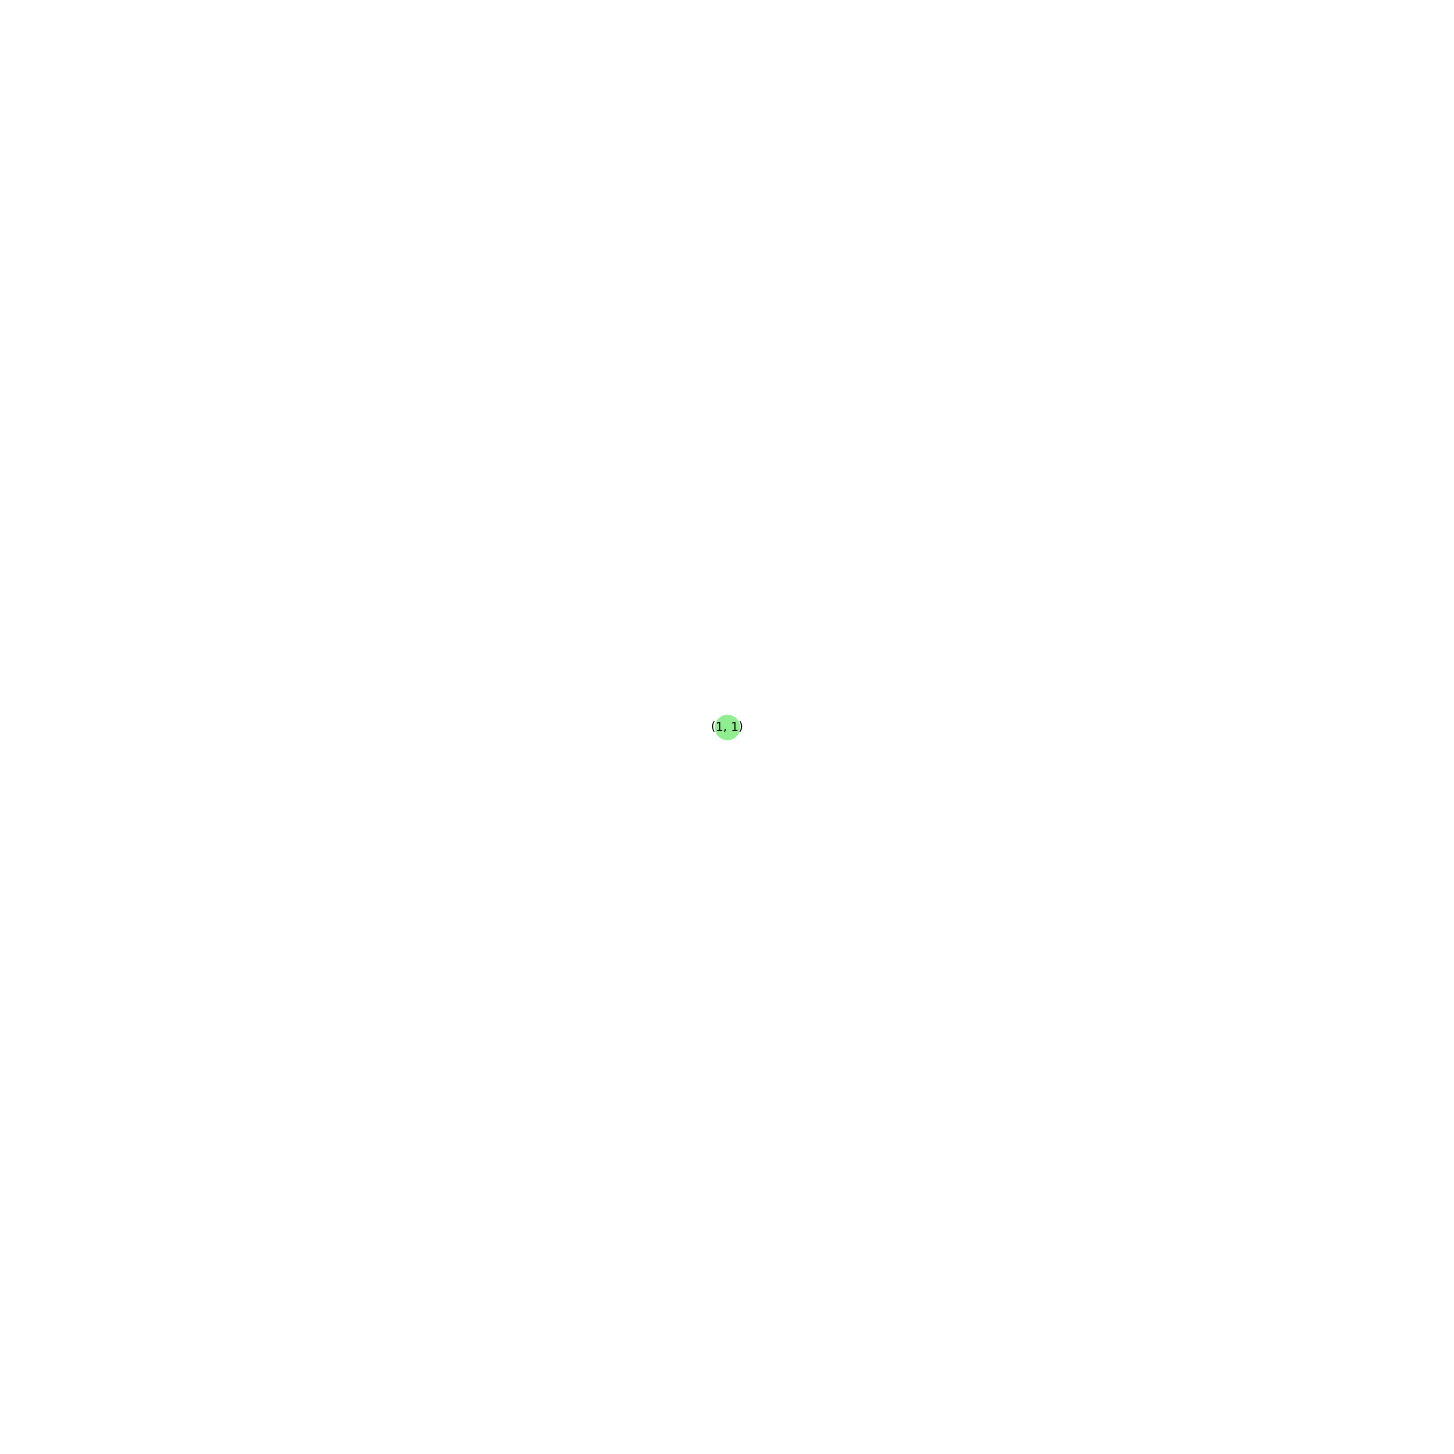

[(1, 1)]
Target cell:(1, 1), chance of wumpus there:0.0,        chance of pit:0.0, chance of death:0.0
next action: climb
Wa-Wa-Wa-Waaa! You lose!
Final score: 0
Do you want to play again? Y or N
y
Move 1.
+---+---+---+---+
|   |   |W  |   |
|   |   |   |   |
+---+---+---+---+
| G |   |   |   |
|   |   |   |   |
+---+---+---+---+
|   |   |   |   |
|   |   |   |   |
+---+---+---+---+
|   |  P|   |   |
| A>|   |   |   |
+---+---+---+---+
['breeze', 0]

['breeze', 0]
unsafe cell(1, 2)detected. Chance of wumpus:0.0, chance of pit: 0.5555555555555551, probability of death:0.5555555555555551

unsafe cell(2, 1)detected. Chance of wumpus:0.0, chance of pit: 0.555555555555555, probability of death:0.555555555555555



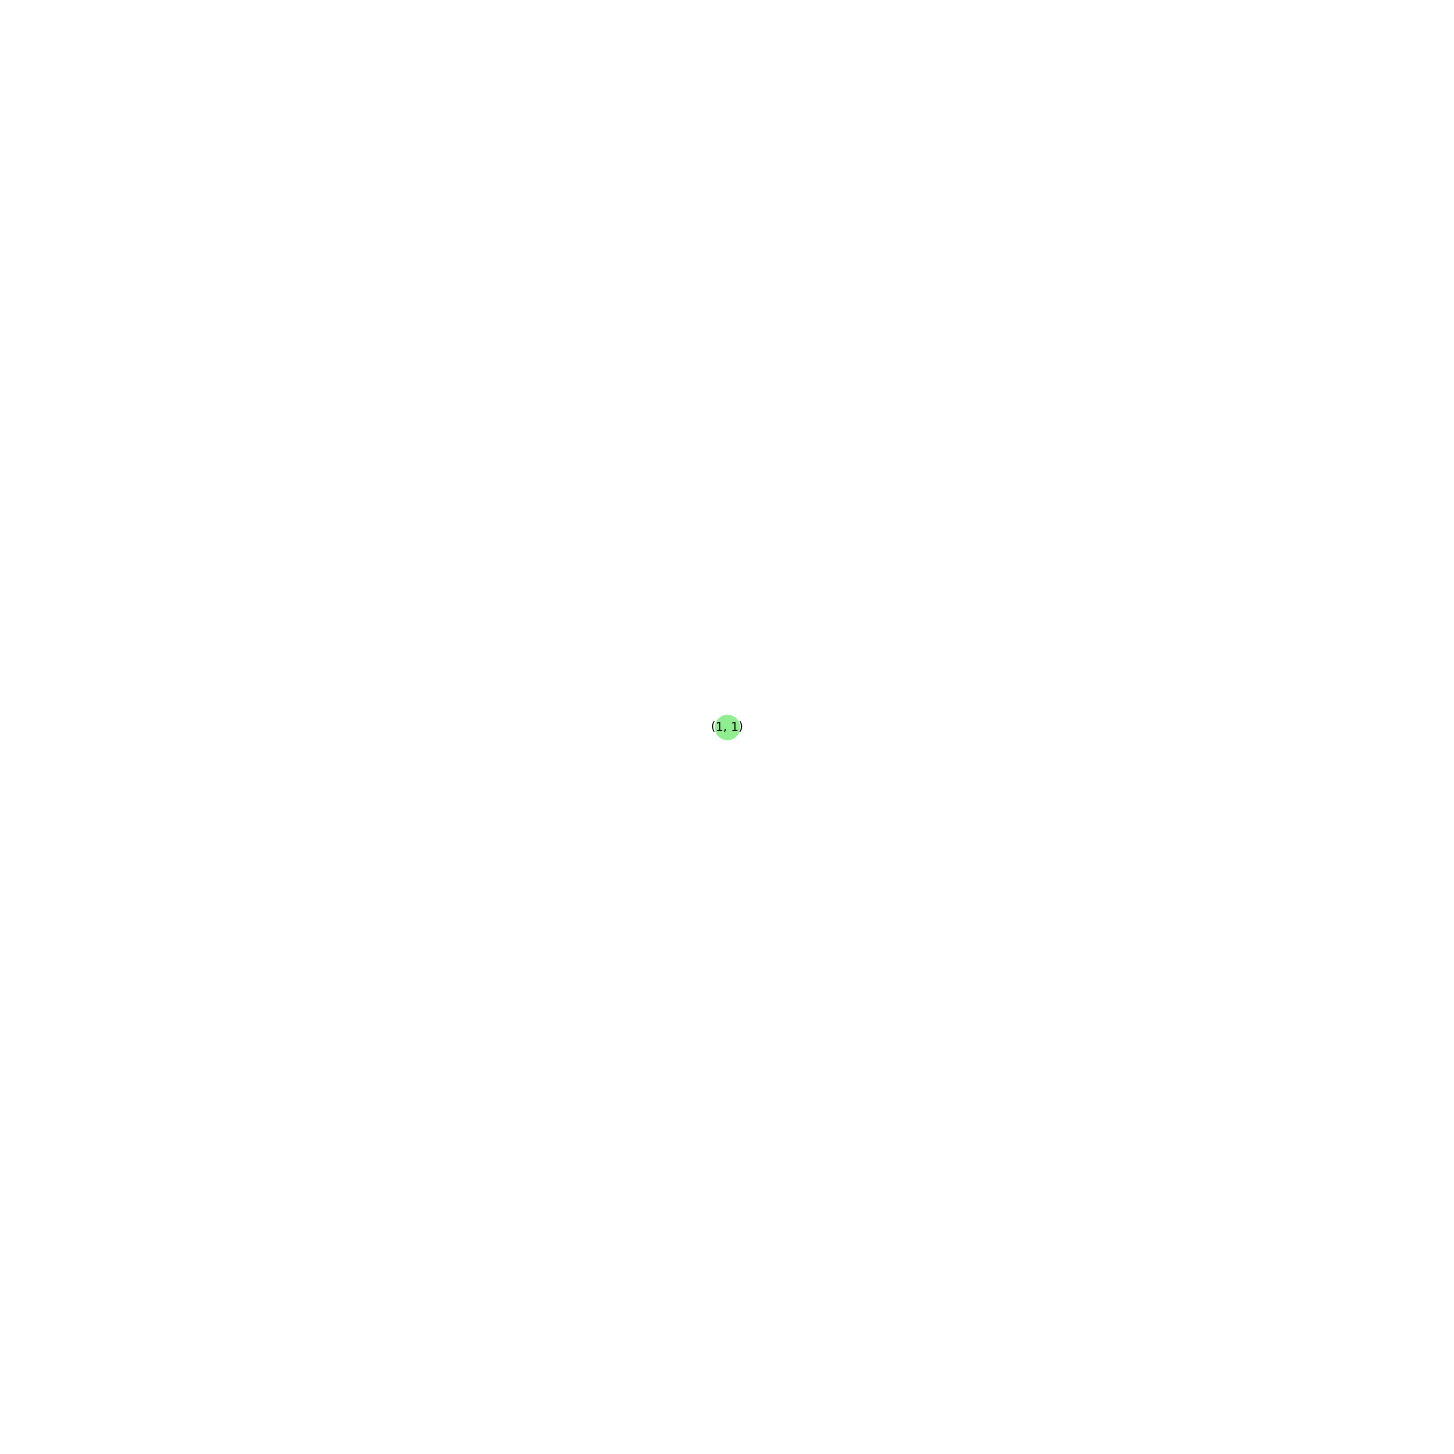

[(1, 1)]
Target cell:(1, 1), chance of wumpus there:0.0,        chance of pit:0.0, chance of death:0.0
next action: climb
Wa-Wa-Wa-Waaa! You lose!
Final score: 0
Do you want to play again? Y or N
y
Move 1.
+---+---+---+---+
|   |  P|   |   |
|   |   |   |   |
+---+---+---+---+
|  P|   |   |   |
|   |   |   |   |
+---+---+---+---+
|  P|   |   |   |
|   |   |   |   |
+---+---+---+---+
|   |W  | G |   |
| A>|   |   |   |
+---+---+---+---+
['breeze', 'stench', 0]

['breeze', 'stench', 0]
unsafe cell(1, 2)detected. Chance of wumpus:0.49999999999999845, chance of pit: 0.5555555555555551, probability of death:0.7777777777777769

unsafe cell(2, 1)detected. Chance of wumpus:0.49999999999999845, chance of pit: 0.555555555555555, probability of death:0.777777777777777



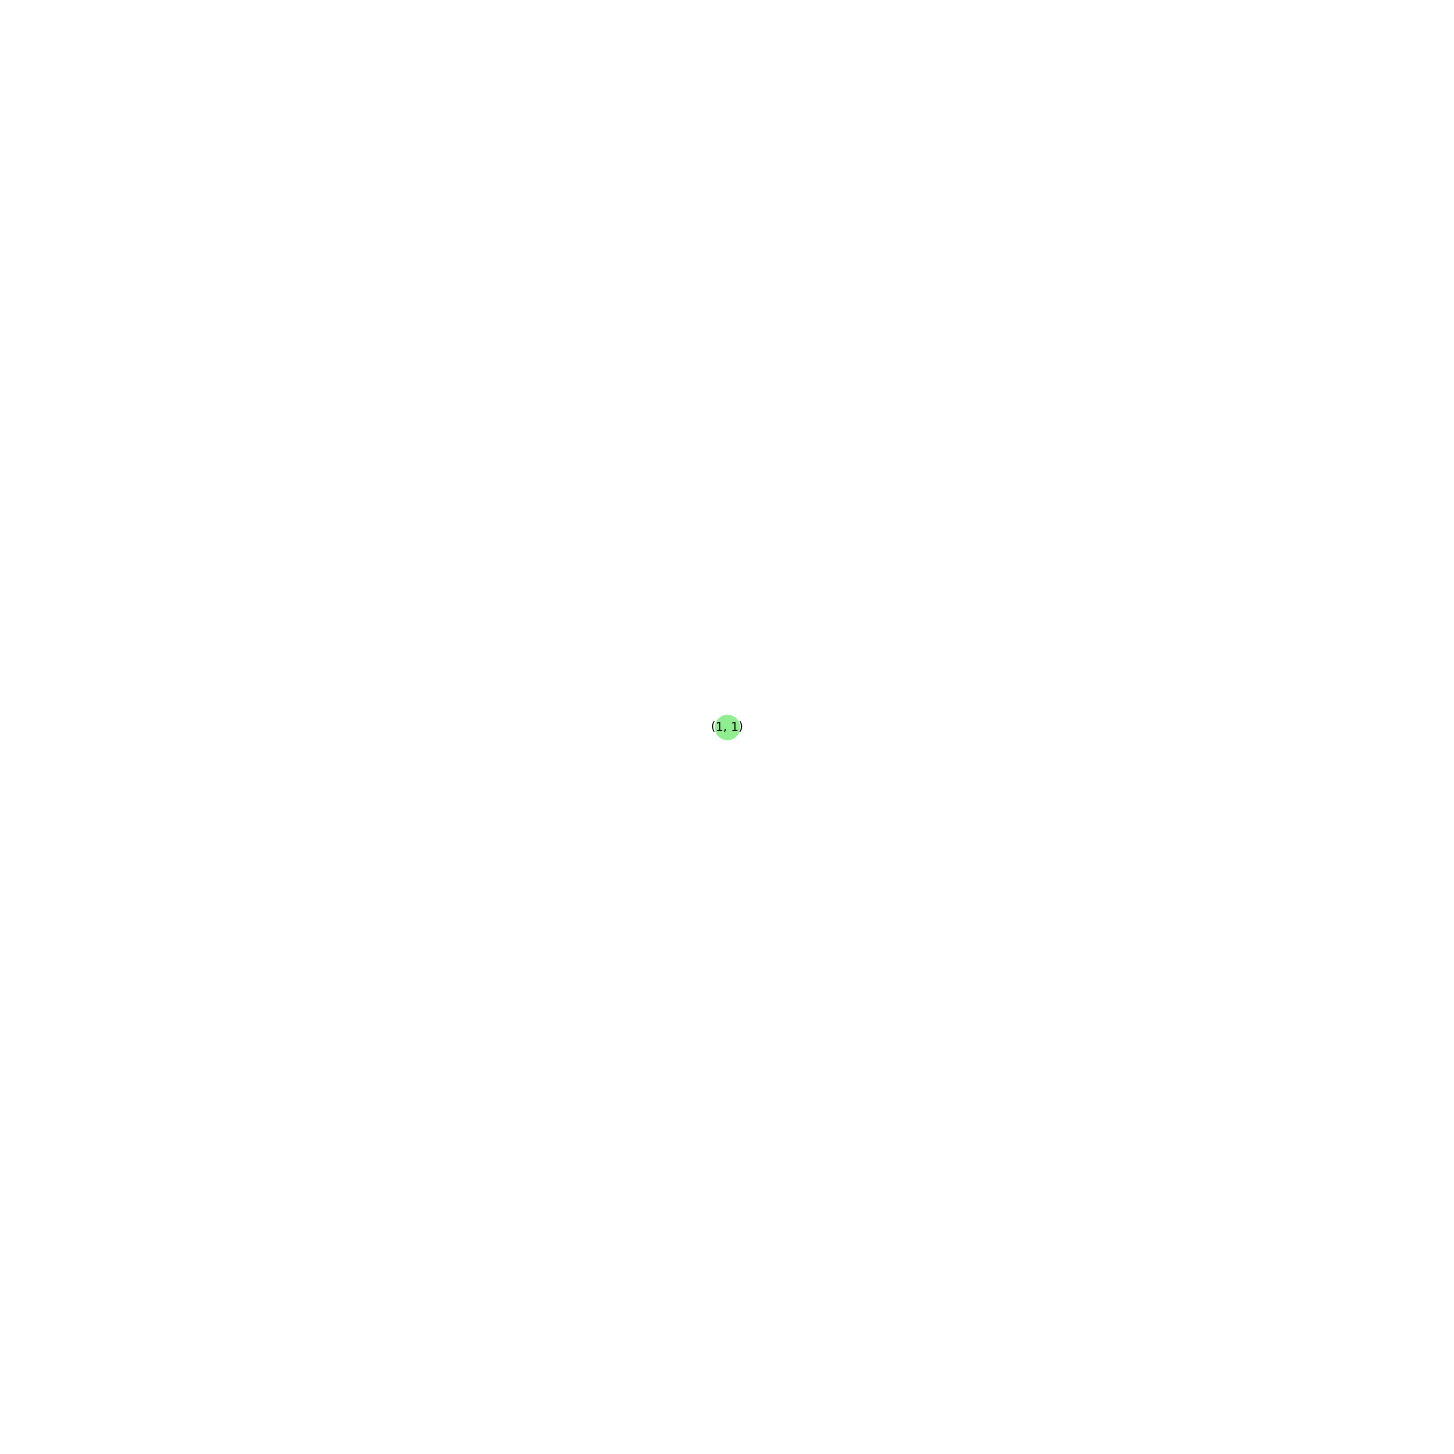

[(1, 1)]
Target cell:(1, 1), chance of wumpus there:0.0,        chance of pit:0.0, chance of death:0.0
next action: climb
Wa-Wa-Wa-Waaa! You lose!
Final score: 0
Do you want to play again? Y or N
y
Move 1.
+---+---+---+---+
|   |   |   |   |
|   |   |   |   |
+---+---+---+---+
|   | GP|   |W  |
|   |   |   |   |
+---+---+---+---+
|   |   |   |  P|
|   |   |   |   |
+---+---+---+---+
|   |   |   |   |
| A>|   |   |   |
+---+---+---+---+
[0]

[0]
Target cell:(2, 1), chance of wumpus there:0.0,        chance of pit:0.0, chance of death:0.0
next action: forward
Move 2.
+---+---+---+---+
|   |   |   |   |
|   |   |   |   |
+---+---+---+---+
|   | GP|   |W  |
|   |   |   |   |
+---+---+---+---+
|   |   |   |  P|
|   |   |   |   |
+---+---+---+---+
|   |   |   |   |
|   | A>|   |   |
+---+---+---+---+
[-1]

[-1]
Target cell:(3, 1), chance of wumpus there:0.0,        chance of pit:0.0, chance of death:0.0
next action: forward
Move 3.
+---+---+---+---+
|   |   |   |   |
|   |   |   |   |
+---+-

unsafe cell(2, 3)detected. Chance of wumpus:0.0, chance of pit: 1.0, probability of death:1.0

unsafe cell(4, 2)detected. Chance of wumpus:0.0, chance of pit: 1.0, probability of death:1.0

unsafe cell(4, 3)detected. Chance of wumpus:1.0, chance of pit: 0.0, probability of death:1.0

Target cell:(3, 4), chance of wumpus there:0.0,        chance of pit:0.0, chance of death:0.0
wumpus probabiliy:{(3, 4): 0.0, (4, 3): 1.0}
next action: turn_right
Move 16.
+---+---+---+---+
|   |   |   |   |
|   |   |   | Av|
+---+---+---+---+
|   | GP|   |W  |
|   |   |   |   |
+---+---+---+---+
|   |   |   |  P|
|   |   |   |   |
+---+---+---+---+
|   |   |   |   |
|   |   |   |   |
+---+---+---+---+
['stench', -15]

['stench', -15]
Target cell:(4, 3), chance of wumpus there:1.0,        chance of pit:0.0, chance of death:1.0
wumpus probabiliy:{(3, 4): 0.0, (4, 3): 1.0}
next action: shoot
Move 17.
+---+---+---+---+
|   |   |   |   |
|   |   |   | Av|
+---+---+---+---+
|   | GP|   |M  |
|   |   |   |   |
+

unsafe cell(4, 2)detected. Chance of wumpus:0, chance of pit: 1.0, probability of death:1.0

Target cell:(4, 4), chance of wumpus there:0,        chance of pit:0.0, chance of death:0.0
next action: forward
Move 30.
+---+---+---+---+
|   |   |   |   |
|   |   |   | A>|
+---+---+---+---+
|   | GP|   |M  |
|   |   |   |   |
+---+---+---+---+
|   |   |   |  P|
|   |   |   |   |
+---+---+---+---+
|   |   |   |   |
|   |   |   |   |
+---+---+---+---+
['stench', -39]

['stench', -39]
unsafe cell(2, 3)detected. Chance of wumpus:0, chance of pit: 1.0, probability of death:1.0

unsafe cell(4, 2)detected. Chance of wumpus:0, chance of pit: 1.0, probability of death:1.0

Target cell:(4, 3), chance of wumpus there:0,        chance of pit:0.0, chance of death:0.0
next action: turn_right
Move 31.
+---+---+---+---+
|   |   |   |   |
|   |   |   | Av|
+---+---+---+---+
|   | GP|   |M  |
|   |   |   |   |
+---+---+---+---+
|   |   |   |  P|
|   |   |   |   |
+---+---+---+---+
|   |   |   |   |
|   |   |

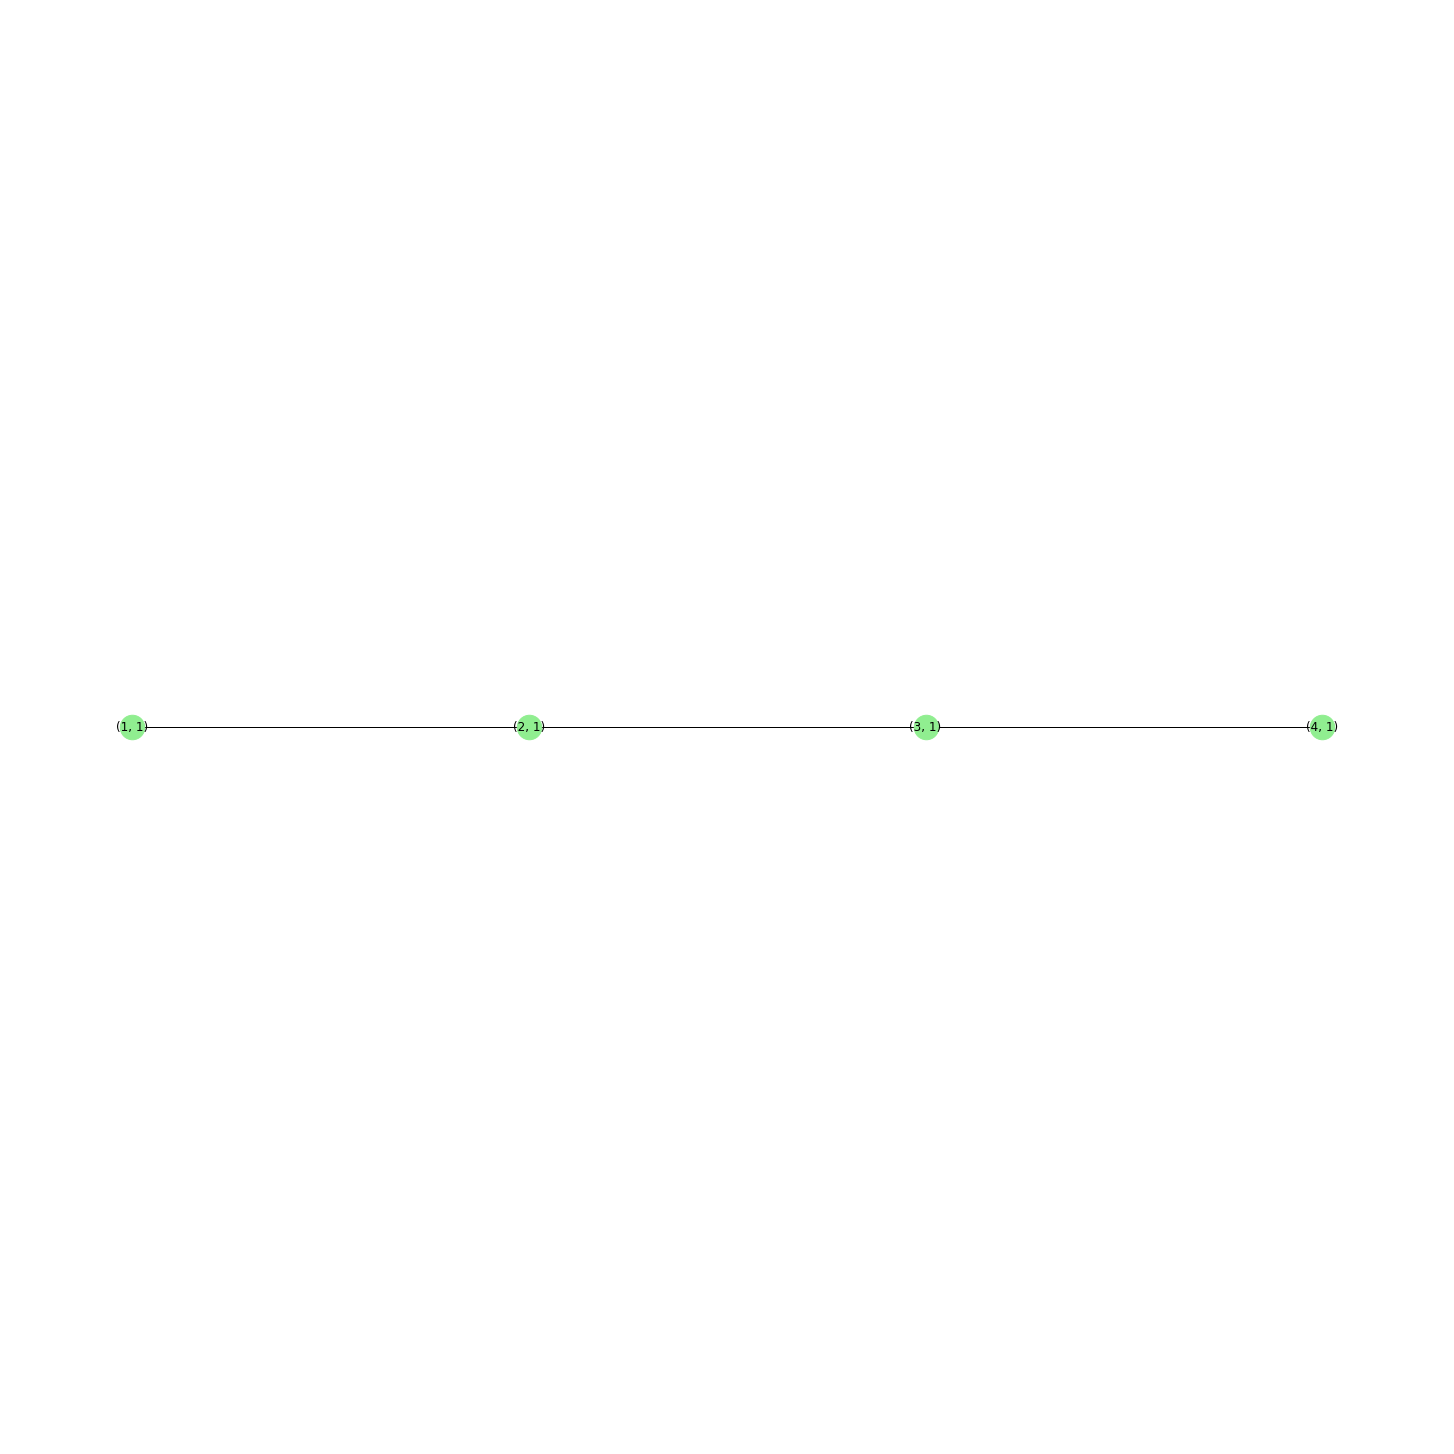

[(4, 1), (3, 1), (2, 1), (1, 1)]
Target cell:(1, 1), chance of wumpus there:0,        chance of pit:0.0, chance of death:0.0
next action: forward
Move 40.
+---+---+---+---+
|   |   |   |   |
|   |   |   |   |
+---+---+---+---+
|   | GP|   |M  |
|   |   |   |   |
+---+---+---+---+
|   |   |   |  P|
|   |   |   |   |
+---+---+---+---+
|   |   |   |   |
|   |   |   | A>|
+---+---+---+---+
['breeze', 'bump', -49]

['breeze', -49]
Target cell:(3, 1), chance of wumpus there:0,        chance of pit:0.0, chance of death:0.0
next action: turn_right
Move 41.
+---+---+---+---+
|   |   |   |   |
|   |   |   |   |
+---+---+---+---+
|   | GP|   |M  |
|   |   |   |   |
+---+---+---+---+
|   |   |   |  P|
|   |   |   |   |
+---+---+---+---+
|   |   |   |   |
|   |   |   | Av|
+---+---+---+---+
['breeze', -50]

['breeze', -50]
Target cell:(3, 1), chance of wumpus there:0,        chance of pit:0.0, chance of death:0.0
next action: turn_right


KeyboardInterrupt: Interrupted by user

In [775]:
#To demonstrate that the agent tries to shoot the wumpus when appropriate:
game_engine(ProbAgent(4)) 

class NaiveAgent():
    def __init__(self):
        self.agent_type = 'naive_agent'
        self.all_actions = ['forward', 'turn_left', 'turn_right', 'grab','shoot', 'climb']
        self.legal_actions = self.all_actions
        self.latest_percept = None
        self.score = None
        
    def next_action(self):
        import random
        return random.choice(self.legal_actions)
    
    def perceive(self, percept):
        self.latest_percept = percept
    